**Group Members:**

* Chandana Vangapalli (ID: 233323)
* Yizhou Yu (ID: 236819)
* Akpany Aubin Benjamin Ebby (ID: 232836 )
* Bangyi Wu (ID: 183398)


**Objective:**

The primary objective of our project is to apply sentiment analysis to the US airline industry twitter data to understand the trends in customer perceptions about some of the biggest airline companies in the USA. Further, we will also investigate what factors drive positive and negative sentiments and how this would impact the overall industry.  


**Data:**

We will use airline industry tweets for our analysis. Alternatively, we may use twitter datasets sourced from Kaggle.


In [1]:
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tree import *

In [4]:
import rpy2.rinterface
# %load_ext rpy2.ipython
library(dplyr)
library(reticulate)
library(ggplot2)
library(rtweet)

ImportError: libgfortran.so.3: cannot open shared object file: No such file or directory

In [2]:
# While hunting in Africa, I shot an elephant in my pajamas. How an elephant got into my pajamas I'll never know.

hunting_sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']

simple_grammar = nltk.CFG.fromstring("""
 S -> NP VP
 PP -> P NP
 NP -> Det N | Det N PP | 'I'
 VP -> V NP | VP PP
 Det -> 'an' | 'my'
 N -> 'elephant' | 'pajamas'
 V -> 'shot'
 P -> 'in'
""")

parser = nltk.ChartParser(simple_grammar)

In [3]:
for tree in parser.parse(hunting_sent):
  print(tree)

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


In [4]:
for tree in parser.parse(hunting_sent):
    tree.pretty_print()

     S                                       
  ___|______________                          
 |                  VP                       
 |         _________|__________               
 |        VP                   PP            
 |    ____|___              ___|___           
 |   |        NP           |       NP        
 |   |     ___|_____       |    ___|_____     
 NP  V   Det        N      P  Det        N   
 |   |    |         |      |   |         |    
 I  shot  an     elephant  in  my     pajamas

     S                                   
  ___|__________                          
 |              VP                       
 |    __________|______                   
 |   |                 NP                
 |   |     ____________|___               
 |   |    |     |          PP            
 |   |    |     |       ___|___           
 |   |    |     |      |       NP        
 |   |    |     |      |    ___|_____     
 NP  V   Det    N      P  Det        N   
 |   |    |     |    

# U.S. Airline Twitter

In [5]:
nltk.download("stopwords") # Load StopWords
tweets_dataset = pd.read_csv("data/US_Airline_Tweets.csv") # Load Data

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Data Exploration**

In [6]:
list(tweets_dataset.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [7]:
tweets_dataset.shape

(14640, 15)

In [8]:
positive_tweets = tweets_dataset['airline_sentiment'].str.contains("positive")
negative_tweets = tweets_dataset['airline_sentiment'].str.contains("negative")
neutral_tweets = tweets_dataset['airline_sentiment'].str.contains("neutral")


print(positive_tweets.shape)
print(negative_tweets.shape)
print(neutral_tweets.shape)

(14640,)
(14640,)
(14640,)


In [9]:
American = tweets_dataset['airline'].str.contains("American")
Delta = tweets_dataset['airline'].str.contains("Delta")
Southwest = tweets_dataset['airline'].str.contains("Southwest")
United = tweets_dataset['airline'].str.contains("United")
VAmerica = tweets_dataset['airline'].str.contains("Virgin America")
USair = tweets_dataset['airline'].str.contains("US Airways")

print(American.shape)
print(Delta.shape)
print(Southwest.shape)
print(United.shape)
print(VAmerica.shape)
print(USair.shape)

(14640,)
(14640,)
(14640,)
(14640,)
(14640,)
(14640,)


**Train Test Split**

In [10]:
tweets_dataset_train, tweets_dataset_test = train_test_split(tweets_dataset, test_size=0.2)

print(tweets_dataset_train.shape)
print(tweets_dataset_test.shape)

(11712, 15)
(2928, 15)


In [1]:
library(dplyr)
library(reticulate)
library(ggplot2)
library(rtweet)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



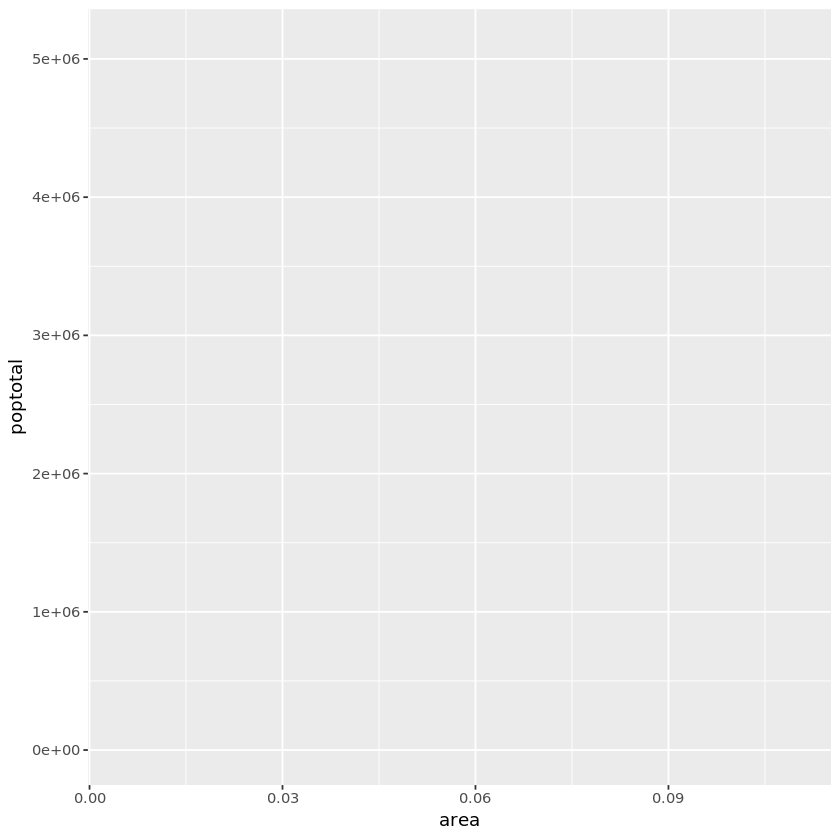

In [5]:
data("midwest", package = "ggplot2")  # load the data
ggplot(midwest, aes(x=area, y=poptotal))  # area and poptotal are columns in 'midwest'

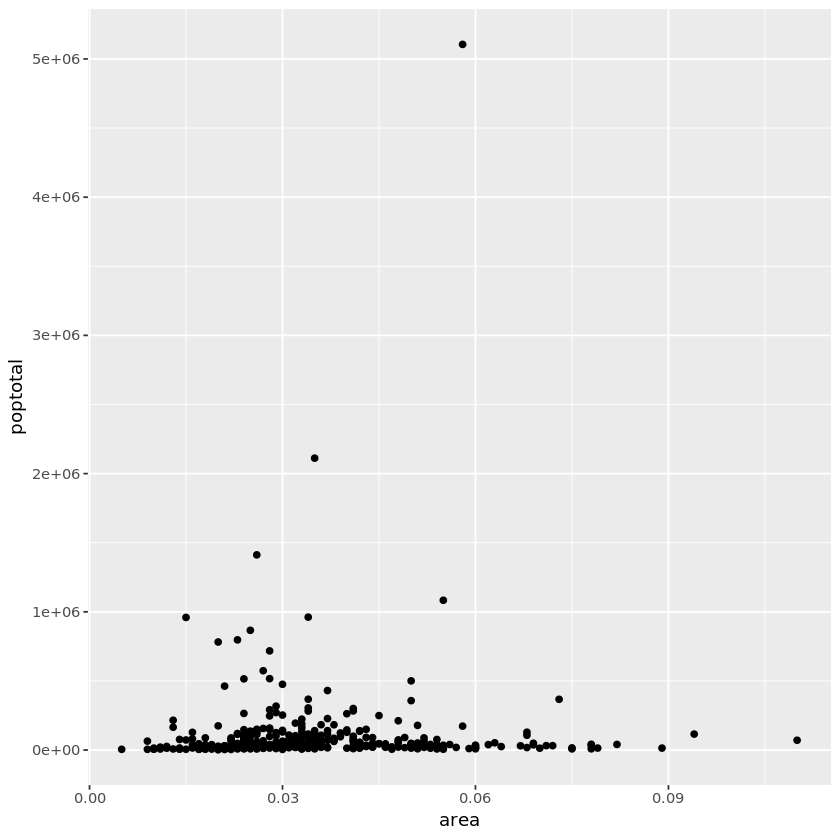

In [6]:
ggplot(midwest, aes(x=area, y=poptotal)) + geom_point()

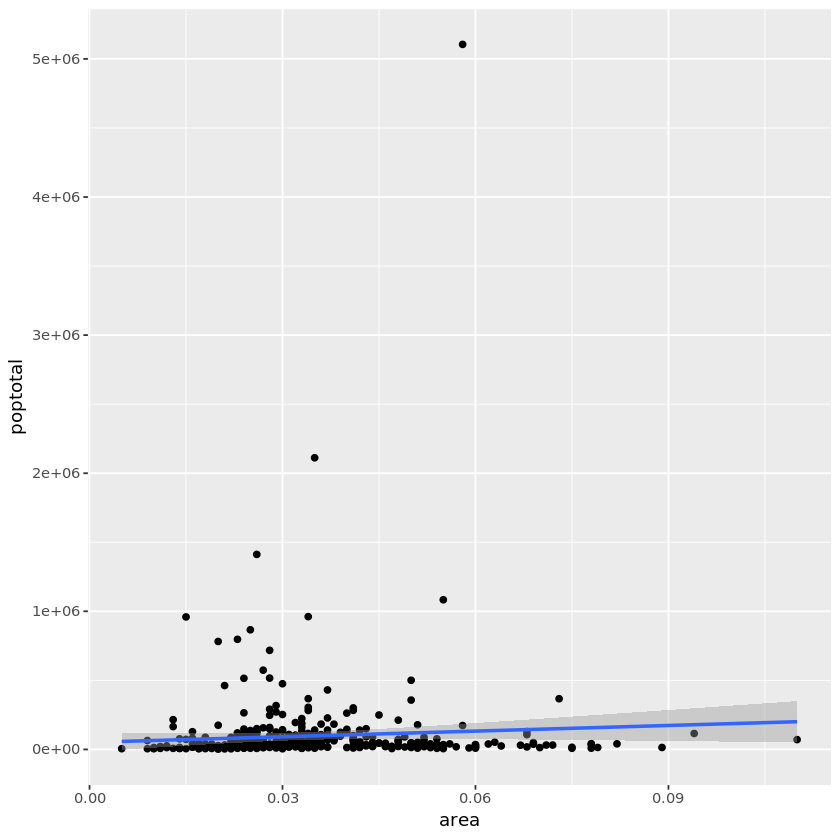

In [7]:
g <- ggplot(midwest, aes(x=area, y=poptotal)) + geom_point() + geom_smooth(method="lm")
plot(g)

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

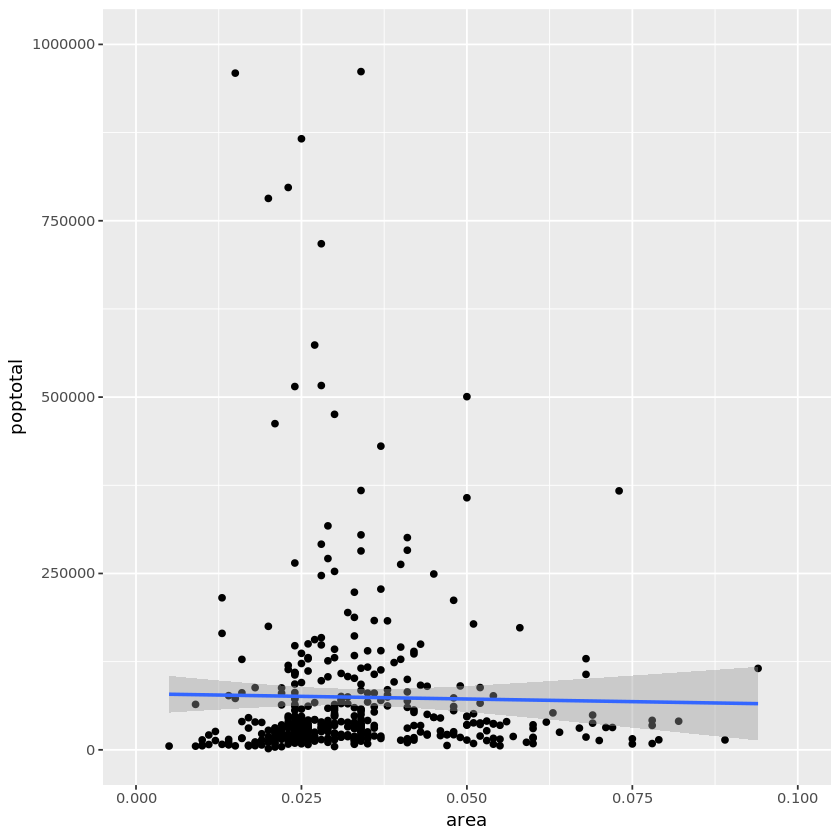

In [8]:
g + xlim(c(0, 0.1)) + ylim(c(0, 1000000))

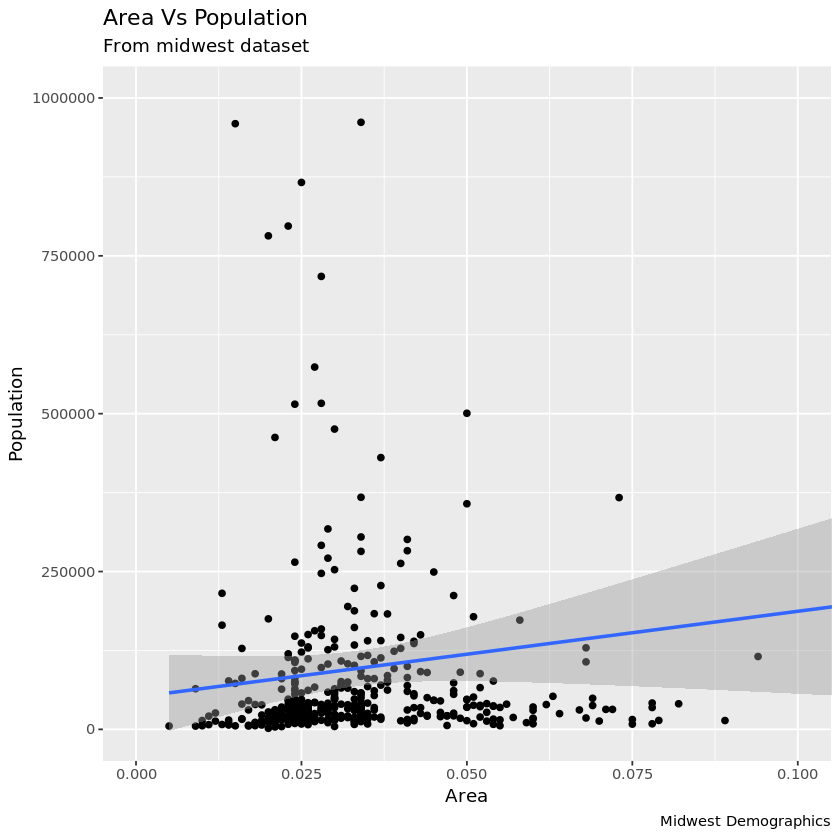

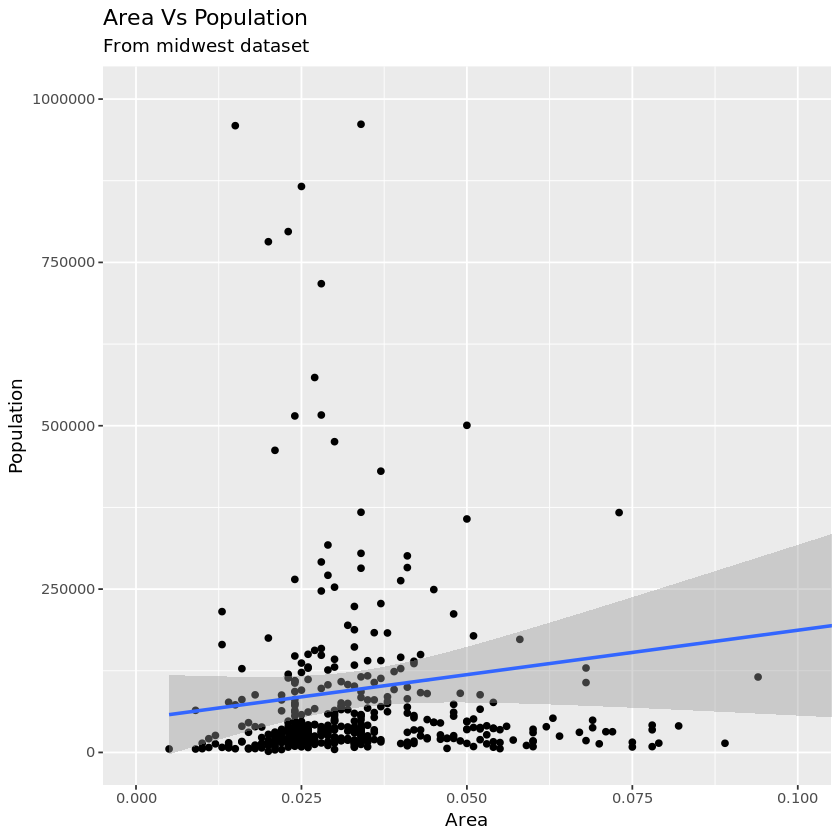

In [9]:
g <- ggplot(midwest, aes(x=area, y=poptotal)) + geom_point() + geom_smooth(method="lm")  # set se=FALSE to turnoff confidence bands

g1 <- g + coord_cartesian(xlim=c(0,0.1), ylim=c(0, 1000000))  # zooms in

# Add Title and Labels
g1 + labs(title="Area Vs Population", subtitle="From midwest dataset", y="Population", x="Area", caption="Midwest Demographics")

# or

g1 + ggtitle("Area Vs Population", subtitle="From midwest dataset") + xlab("Area") + ylab("Population")

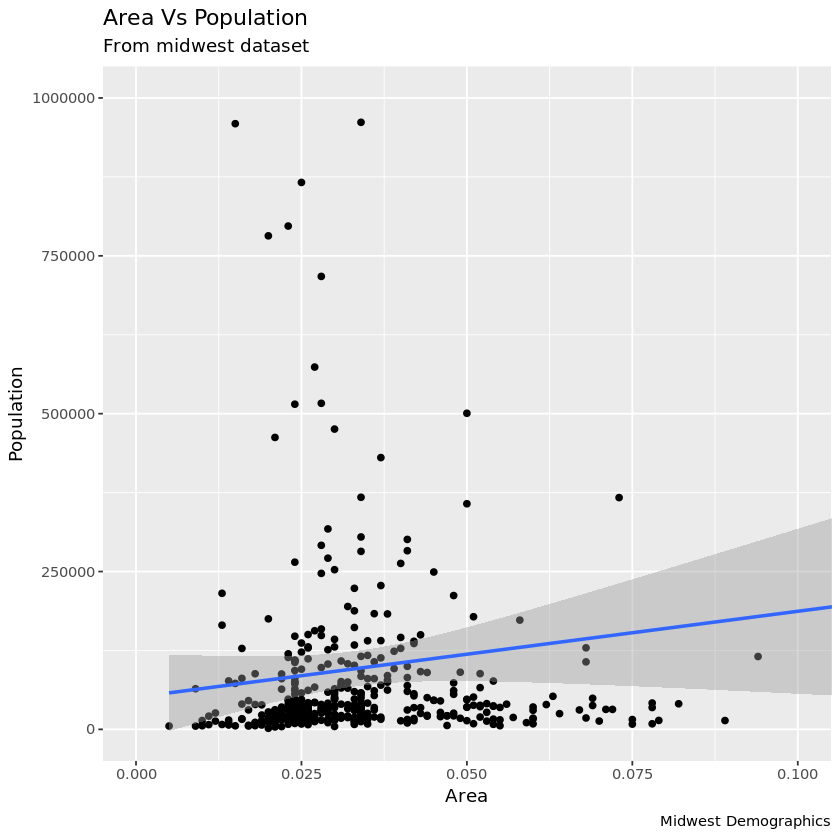

In [10]:
# Full Plot call
library(ggplot2)
ggplot(midwest, aes(x=area, y=poptotal)) + 
  geom_point() + 
  geom_smooth(method="lm") + 
  coord_cartesian(xlim=c(0,0.1), ylim=c(0, 1000000)) + 
  labs(title="Area Vs Population", subtitle="From midwest dataset", y="Population", x="Area", caption="Midwest Demographics")

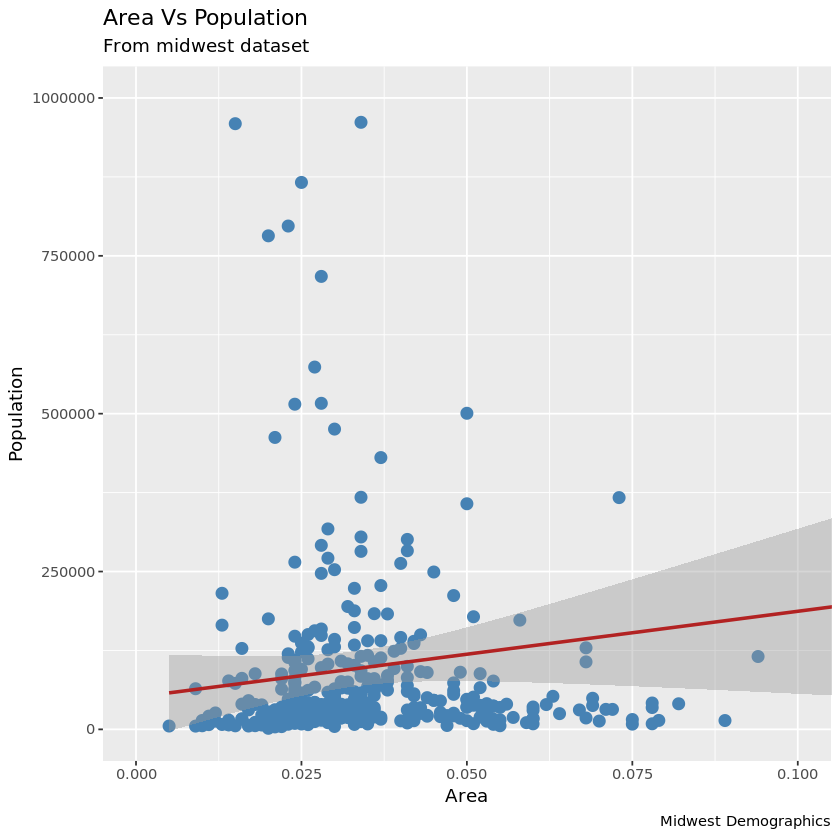

In [11]:
library(ggplot2)
ggplot(midwest, aes(x=area, y=poptotal)) + 
  geom_point(col="steelblue", size=3) +   # Set static color and size for points
  geom_smooth(method="lm", col="firebrick") +  # change the color of line
  coord_cartesian(xlim=c(0, 0.1), ylim=c(0, 1000000)) + 
  labs(title="Area Vs Population", subtitle="From midwest dataset", y="Population", x="Area", caption="Midwest Demographics")

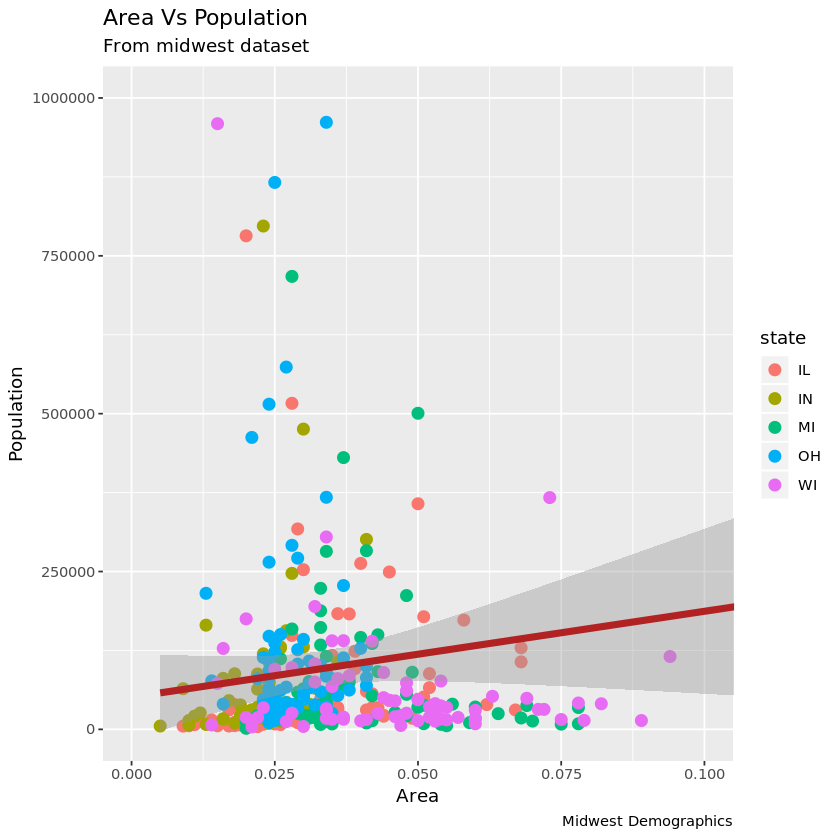

In [12]:
gg <- ggplot(midwest, aes(x=area, y=poptotal)) + 
  geom_point(aes(col=state), size=3) +  # Set color to vary based on state categories.
  geom_smooth(method="lm", col="firebrick", size=2) + 
  coord_cartesian(xlim=c(0, 0.1), ylim=c(0, 1000000)) + 
  labs(title="Area Vs Population", subtitle="From midwest dataset", y="Population", x="Area", caption="Midwest Demographics")
plot(gg)

In [13]:
library(RColorBrewer)
head(brewer.pal.info, 10)

,maxcolors,category,colorblind
BrBG,11,div,TRUE
PiYG,11,div,TRUE
PRGn,11,div,TRUE
PuOr,11,div,TRUE
RdBu,11,div,TRUE
RdGy,11,div,FALSE
RdYlBu,11,div,TRUE
RdYlGn,11,div,FALSE
Spectral,11,div,FALSE
Accent,8,qual,FALSE


In [17]:
tweets_dataset

ERROR: Error in eval(expr, envir, enclos): object 'tweets_dataset' not found
